In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Study Summary
A study seeks to quantify the effectiveness of a drug in a clinical population with systemic hypertension (SH). The team enrolled 250 patients with diagnosis of SH and no other known comorbidities. For each individual, the systolic blood pressure was measured after a minimum of 12 hours of fasting. Then, a random safe dose of the tested drug within acceptable thresholds was administered daily during a period of 30 days, after which the systolic blood pressure was measured again.

The principal investigator of this project is interested in quantifying if the systolic blood pressure can be predicted after 30 days of treatment based on the measured values before the treatment, the administered drug dose and basic patient information such as age and/or sex.

In [2]:
# Import data
WORK_DIR = os.getcwd()
filename = 'BloodPressureData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),"Sex (0:female, 1:male)",Initial systolic pressure (mm Hg),Drug dose (mg),Systolic pressure after treatment (mm Hg)
0,86,0,171.221889,7.144833,153.874218
1,79,0,166.426064,7.984246,143.468111
2,90,1,163.676760,7.271092,148.559803
3,85,1,146.621486,7.770628,124.180775
4,81,1,142.752645,7.233099,123.560301


# Note

Usually we would perform a more extensive EDA/data cleaning section checking variable/outcome distributions, evidence of multicollinearity, missing data, outliers, etc. The focus of this notebook is on model fitting/evaluation. Later modules will incorporate the EDA/data cleaning techniques. Additionally, we had not covered cross-validation implementation at this point in the course, so there are obvious limitations to the approach here.

# Functions

Defining functions used throughout the report

In [3]:
# Function to plot residuals vs outcome
def resid_outcome_scatter(df, x_col, y_col):
    plt.style.use('seaborn')
    resid_plot = sns.JointGrid(data=data, x=x_col, y=y_col)
    resid_plot.plot_joint(sns.residplot, lowess=True, scatter_kws={'alpha': 0.6}, line_kws={'color': 'r'})
    resid_plot.plot_marginals(sns.histplot)
    resid_plot.set_axis_labels(xlabel=x_col, ylabel=y_col, fontsize=16)
    resid_plot.fig.set_figwidth(8)
    resid_plot.fig.set_figheight(5)
    plt.show()

# Function to plot residuals vs features
def resid_scatter(df, x_col, y_col, categorical: bool, ax):
    plt.style.use('seaborn')
    if categorical:
        sns.boxenplot(data=df, x=x_col, y=y_col, ax=ax)
        plt.xlabel(x_col, fontsize=16)
        plt.ylabel(y_col, fontsize=16)
    else:
        sns.residplot(
            data=df, x=x_col, y=y_col, ax=ax, lowess=True, scatter_kws={'alpha': 0.6}, line_kws={'color': 'r'})
        plt.xlabel(x_col, fontsize=16)
        plt.ylabel(y_col, fontsize=16)
        
# Function to calculate adjusted r-squared
def r2_adj_score(y, y_pred, n, k):
    return 1 - ((1-r2_score(y, y_pred))*(n-1)/(n-k-1))

# Linear Regression Model
Build and evaluate a regression model that can predict the systolic blood pressure after 30 days of treatment.

In [4]:
# Choose features and target and represent as numpy matrices
X = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].to_numpy()
y = data.loc[:, 'Systolic pressure after treatment (mm Hg)'].to_numpy()

In [5]:
# State variables in terms of x1, x2, x3, x4 - want to pull directly from data set
model_varnames = [f'x{i+1}' for i in range(0, len(data.columns)-1)]
varnames = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].columns
varname_dict = dict(zip(model_varnames, varnames))
for key, value in varname_dict.items():
    print(f'{key}: {value}')

x1: Age (years)
x2: Sex (0:female, 1:male)
x3: Initial systolic pressure (mm Hg)
x4: Drug dose (mg)


## Model Equation

$$\hat{y} = \theta_0 + \theta_{1}x_1 + \theta_{2}x_2 + \theta_{3}x_3 + \theta_{4}x_4$$

$$\hat{y} = -7.40 + 0.06x_1 + 2.79x_2 + 1.02x_3 + -3.07x_4$$

Where...
- $\hat{y}$ is the target outcome, systolic pressure after treatment (mm Hg)
- $x_1$, $x_2$, $x_3$, and $x_4$ are the features
- $\theta_1$, $\theta_2$, $\theta_3$, and $\theta_4$ are the coefficients associated with each feature
- $\theta_0$ is the intercept, which is uninterpretable in this case

## Model Summary

In [6]:
# Fit model and display results
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1489.
Date:                Wed, 04 Jan 2023   Prob (F-statistic):          1.48e-170
Time:                        18:10:02   Log-Likelihood:                -651.85
No. Observations:                 250   AIC:                             1314.
Df Residuals:                     245   BIC:                             1331.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4072      3.216     -2.303      0.022     -13.741      -1.073
x1             0.0583      0.024      2.386      0.018       0.010       0.107
x2             2.7864      0.422      6.610      0.000       1.956       3.617
x3             1.0224      0.015     70.299      0.000       0.994       1.051
x4            -3.0678      0.133    -23.091      0.000      -3.329      -2.806
==============================================================================
Omnibus:                       47.063   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.884
Skew:                           1.076   Prob(JB):                     9.04e-17
Kurtosis:                       4.570   Cond. No.                     2.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# Predict systolic blood pressure after treatment using linear regression model
predictions = model.predict(X)
data['Prediction (mm Hg)'] = predictions
data['Residuals'] = model.resid

## Performance Evaluation

In [8]:
# Print performance metrics
print(f'MAE: {round(mean_absolute_error(y, predictions), 2)}')
print(f'MSE: {round(mean_squared_error(y, predictions), 2)}')
print(f'R-squared: {round(r2_score(y, predictions), 3)}')
print(f'Adjusted R-squared: {round(model.rsquared_adj, 3)}')

MAE: 2.55
MSE: 10.77
R-squared: 0.96
Adjusted R-squared: 0.96


- **Mean absolute error** does not penalize large prediction errors. An MAE of 2.55 is achieved by this model, compared to a perfect score of 0.
- **Mean squared error (MSE)** penalizes large prediction errors. An MSE of 10.77 is achieved by this model, compared to a perfect score of 0. The discrepancy that exists between MAE and MSE for this model might suggest the presence of some outlier residuals - although the discrepancy isn't large.
- **R-squared & Adjusted R-squared** are each 0.960. Considering perfect scores of 1 for these metrics, $R^2$ of 0.96 suggests good model performance.
  
*The next section asseses the relationship between residuals and features to check if model assumptions are met*

## Residuals vs Predicted Outcome
The residual distribution is not evenly/normally distributed around zero. The skew exists due to large residual values above the y axis - these are observations in which the model underpredicted the true value.

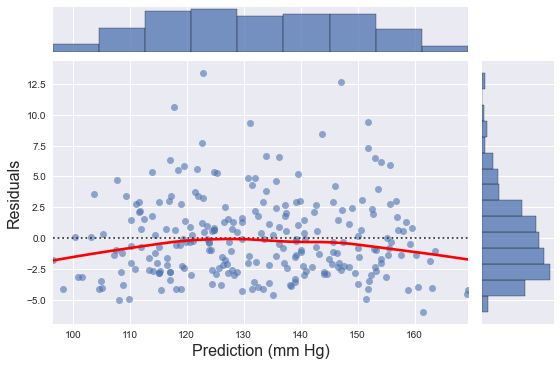

In [9]:
resid_outcome_scatter(df=data, x_col='Prediction (mm Hg)', y_col='Residuals')

## Residuals vs Features

### Residuals vs Age

Age is associated with a $\theta$ value of 0.05 and a $p$-value of 0.018, suggesting a significant association between age and the outcome predicted. Theoretically, a $\theta$ value of 0.05 indicates that for every 1 year increase in age, systolic blood pressure increases by 0.05 units (mm Hg). However, the residual plot below shows a clear non-linear (parabolic) relationship between prediction error and age. This pattern tells us that a non-linear relationship likely exists between age and the outcome. We ought to update the linear regression model to account for this.

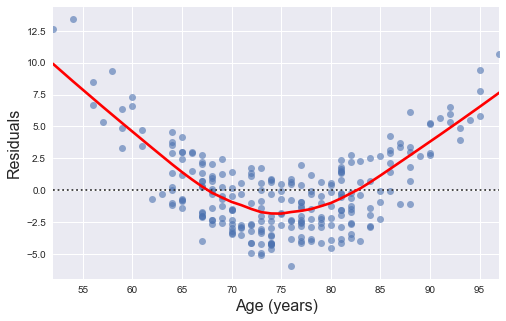

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
resid_scatter(df=data, x_col='Age (years)', y_col='Residuals', categorical=False, ax=ax)

### Residuals vs Sex
Age is associated with a $\theta$ value of 2.78 and a $p$-value of <0.001, suggesting a significant association between sex and the outcome predicted. A $\theta$ value of 2.78 indicates that males, on average, are associated with a 2.78 unit increase in systolic blood pressure when compared to females.

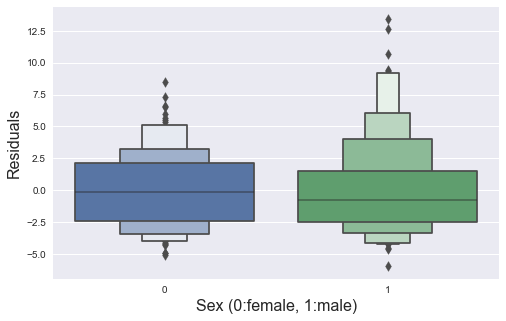

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
resid_scatter(df=data, x_col='Sex (0:female, 1:male)', y_col='Residuals', categorical=True, ax=ax)

### Initial Systolic Blood Pressure
Age is associated with a $\theta$ value of 1.02 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of 1.02 indicates that for every 1 unit increase in initial systolic blood pressure (mm Hg), systolic blood pressure increases by 1.02 units (mm Hg). The residual plot below indicates that a linear relationship likely exists between the variable and the outcome.

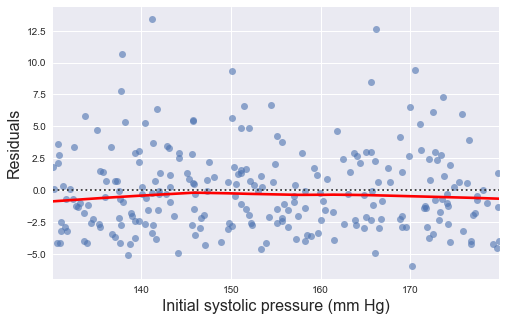

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
resid_scatter(df=data, x_col='Initial systolic pressure (mm Hg)', y_col='Residuals', categorical=False, ax=ax)

### Drug Dose
Drug dose is associated with a $\theta$ value of -3.07 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of -3.07 indicates that for every 1 unit increase in drug dose (mg), systolic blood pressure decreases by 3.07 units (mm Hg). However, the residual plot below indicates that a non-linear relationship might exist between the variable and the outcome. This isn't as obvious as the pattern observed for age, but some optimization can likely be done.

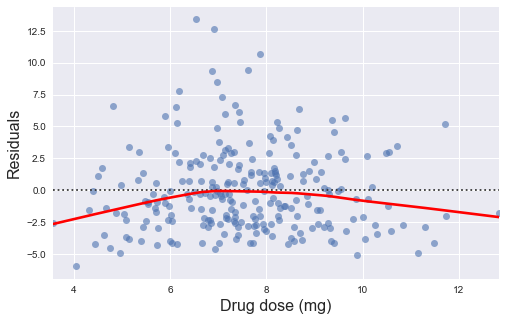

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
resid_scatter(df=data, x_col='Drug dose (mg)', y_col='Residuals', categorical=False, ax=ax)

# Non-Linear Regression Model

$$\hat{y} = \theta_0 + (\theta_{1_1}x_1 + \theta_{1_2}x_1^2) + \theta_{2}x_2 + (\theta_{3_1}x_3 + \theta_{3_2}x_3^2) + (\theta_{4_1}x_4 + \theta_{4_2}x_4^2)$$

In [14]:
def nonlin_func(X, theta0, theta1_1, theta1_2, theta2, theta3_1, theta3_2, theta4_1, theta4_2):
    '''
    Non-linear function to account for non-linear relationships in linear regression model;
    Use with scipy.optimize.curve_fit
    '''
    x1, x2, x3, x4 = X[:, 1], X[:, 2], X[:, 3], X[:, 4]
    return (theta0) + (theta1_1*x1) + (theta1_2*(x1**2)) + (theta2*x2) + (theta3_1*x3) + (theta3_2*(x3**2)) + (theta4_1*x4) + (theta4_2*(x4**2))

# Fit non-linear regression model and extract
popt, pcov = curve_fit(nonlin_func, X, y)
y_pred = nonlin_func(X, *popt)
nonlin_residuals = y - y_pred
data['Non-Linear Model Prediction'] = y_pred
data['Non-Linear Residuals'] = nonlin_residuals


## Performance Evaluation

In [15]:
# Print performance metrics
print(f'MAE: {round(mean_absolute_error(y, y_pred), 2)}')
print(f'MSE: {round(mean_squared_error(y, y_pred), 2)}')
print(f'R-squared: {round(r2_score(y, y_pred), 3)}')
print(f'Adjusted R-squared: {round(r2_adj_score(y, y_pred, n=250, k=8), 3)}')

MAE: 1.59
MSE: 3.41
R-squared: 0.988
Adjusted R-squared: 0.987


## Residuals vs Predicted Outcome
The residual distribution is now evenly/approximately normally distributed around zero, which is good to see. Residual range is now roughly (-4, 4) versus (-5, 13), indicating that the model is no longer heavily underpredicting true values for some observations.

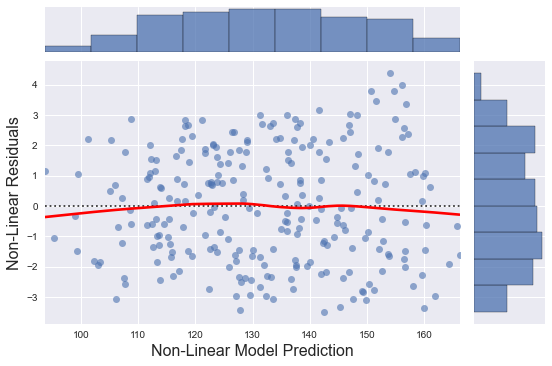

In [16]:
resid_outcome_scatter(df=data, x_col='Non-Linear Model Prediction', y_col='Non-Linear Residuals')

## Residuals vs Features
Adding in quadratic terms for each of the numeric features seems to improve the model quite a bit (especially when looking at the residuals). Adjusted $R^2$ also improved to 0.987 suggesting improved fit. I originally didn't plan on adding in an extra non-linear term for initial systolic blood pressure, but non-linearity was observed in the plot above when the extra term was not included. With this being said, adding extra terms and parameters to a model comes at a cost. So, it isn't always feasible to take this approach.

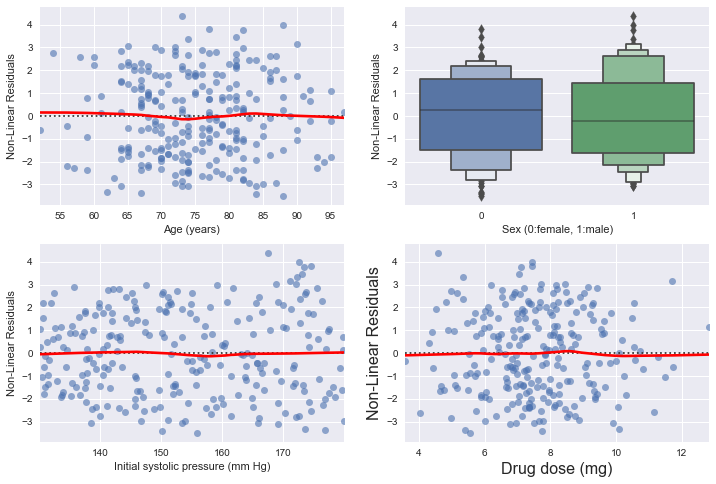

In [17]:
# Set figure space
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plots = []
for ax in axs:
    for plot in ax:
        plots.append(plot)

# Plot residuals vs all features
resid_scatter(df=data, x_col='Age (years)', y_col='Non-Linear Residuals', categorical=False, ax=plots[0])
resid_scatter(df=data, x_col='Sex (0:female, 1:male)', y_col='Non-Linear Residuals', categorical=True, ax=plots[1])
resid_scatter(df=data, x_col='Initial systolic pressure (mm Hg)', y_col='Non-Linear Residuals', categorical=False, ax=plots[2])
resid_scatter(df=data, x_col='Drug dose (mg)', y_col='Non-Linear Residuals', categorical=False, ax=plots[3])
